
# Energy Efficiency Dataset — Feature Engineering & Preprocessing

## 1. Introduction

This notebook implements the **feature engineering and preprocessing pipeline** for the Energy Efficiency dataset. It processes the cleaned data from `1.2-clean-fill.ipynb` and prepares it for model training.

### What This Notebook Does:

**Input:** Clean dataset from `energy_efficiency_clean_fill.csv` (output of notebook 1.2)  
**Output:** Ready-to-train datasets with encoded and scaled features

The preprocessing workflow includes:
- Data loading and type validation
- Duplicate removal
- Exploratory data analysis (EDA)
- Feature selection (correlation-based)
- Train-test split (preventing data leakage)
- One-Hot encoding for categorical variables
- MinMax scaling for numeric features
- PCA visualization (for exploratory purposes only — NOT used in modeling)
- Dataset export for model training

---

## Workflow Overview

1. **Data Loading & Type Validation** — Load cleaned data and ensure correct types
2. **Data Cleaning** — Remove duplicate rows
3. **Exploratory Data Analysis** — Visualize distributions, correlations, and relationships
4. **Feature Selection** — Remove highly correlated features (X2, X4)
5. **Train-Test Split** — Split data before applying transformations to prevent data leakage
6. **Feature Encoding** — One-Hot encode categorical variables (X6, X8)
7. **Feature Scaling** — Normalize numeric features to [0, 1] range using MinMaxScaler
8. **PCA Visualization** — 2D projection for exploratory purposes (NOT used for modeling)
9. **Save Preprocessed Data** — Export train and test sets + encoders/scalers

**Important:** All transformers (encoder, scaler) are **fit only on training data** and saved for use in production pipelines.

---



## 2) Data Loading & Type Validation

This section loads the cleaned dataset from `1.2-clean-fill.ipynb` and performs initial inspections:
- Dataset shape and structure
- Data types verification
- Missing values check
- Type correction for categorical variables (X6, X8)

**Note:** X6 (Orientation) and X8 (Glazing Area Distribution) should be categorical but are read as float64 from CSV. We correct this to maintain consistency with the previous notebook.


In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (7, 5)

DATA_PATH = r"../data/processed/energy_efficiency_clean_fill.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


In [2]:
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

Shape: (731, 10)

Dtypes:
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6    float64
X7    float64
X8    float64
Y1    float64
Y2    float64
dtype: object

Missing values per column:
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


### Type Correction for Categorical Variables

CSV format does not preserve pandas data types. X6 and X8 were saved as `category` in notebook 1.2, but are read as `float64` here. We convert them back to `category` to maintain semantic consistency and optimize memory usage.

In [3]:
df = df.astype({'X6': 'category', 'X8': 'category'})

## 3) Data Cleaning — Duplicate Removal

Even after previous cleaning steps, the dataset may contain exact duplicate rows. These can arise from:
- Data collection errors
- Repeated measurements under identical conditions

We identify and remove all exact duplicates to ensure data quality and prevent model overfitting to repeated observations.

In [4]:
# Drop duplicates
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate rows.")

print("\nDtypes after cleaning:")
print(df.dtypes)

Dropped 10 duplicate rows.

Dtypes after cleaning:
X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6    category
X7     float64
X8    category
Y1     float64
Y2     float64
dtype: object



## 4) Exploratory Data Analysis (EDA)

This section performs a comprehensive exploratory analysis to understand:
- **Descriptive statistics** — Mean, standard deviation, min, max, quartiles
- **Distributions** — Histograms with KDE for continuous variables
- **Categorical distributions** — Count plots for X6 (Orientation) and X8 (Glazing Area)
- **Relationships** — Pairplot to visualize interactions between features
- **Correlations** — Heatmap to identify multicollinearity

**Target Variables:**
- `Y1` — Heating Load (kWh/m²)
- `Y2` — Cooling Load (kWh/m²)


In [5]:
print("Descriptive statistics (numerical columns):\n")
display(df.describe().T)

Descriptive statistics (numerical columns):



,count,mean,std,min,25%,50%,75%,max
X1,721.0,0.764799,0.105288,0.62,0.69,0.76,0.86,0.98
X2,721.0,673.895284,97.066106,514.50,588.00,686.00,735.00,1453.50
X3,721.0,319.385576,46.099083,245.00,294.00,318.50,343.00,597.50
X4,721.0,178.500000,53.250057,110.25,147.00,220.50,220.50,711.50
X5,721.0,5.300971,1.750472,3.50,3.50,7.00,7.00,7.00
X7,721.0,0.237379,0.134939,0.00,0.10,0.25,0.40,1.00
Y1,721.0,22.318094,10.054793,6.01,13.00,19.27,31.66,42.96
Y2,721.0,24.658821,9.472405,10.90,15.73,23.11,33.04,48.03


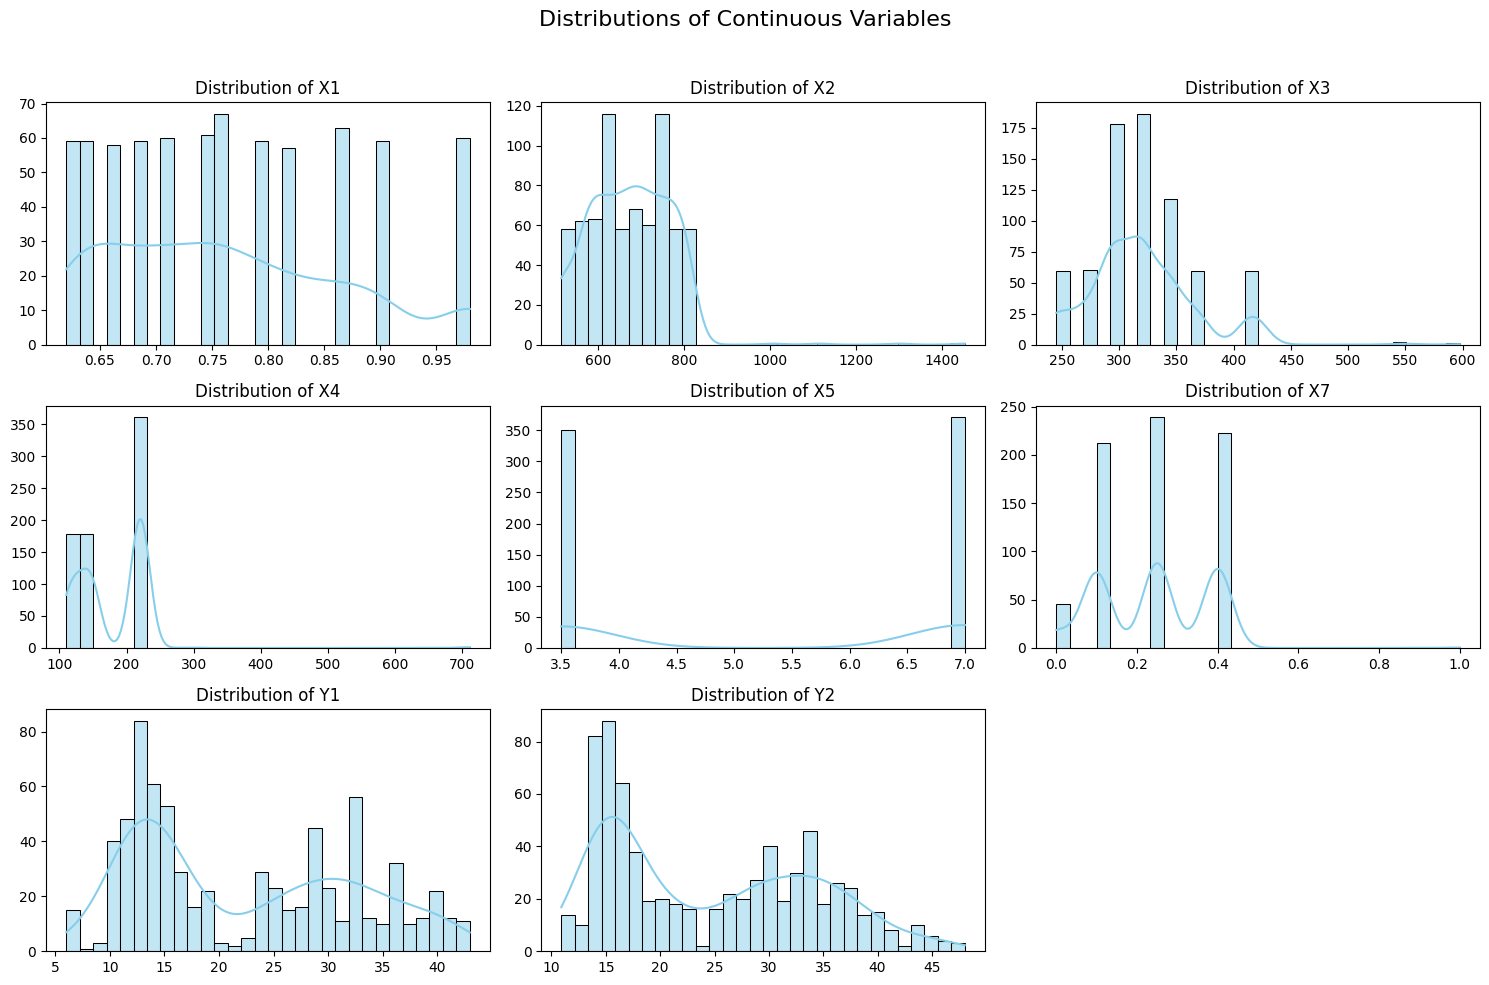

In [6]:
continuous_cols = ['X1','X2','X3','X4','X5','X7','Y1','Y2']

n_cols = 3
n_rows = (len(continuous_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.histplot(data=df, x=col, bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distributions of Continuous Variables", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

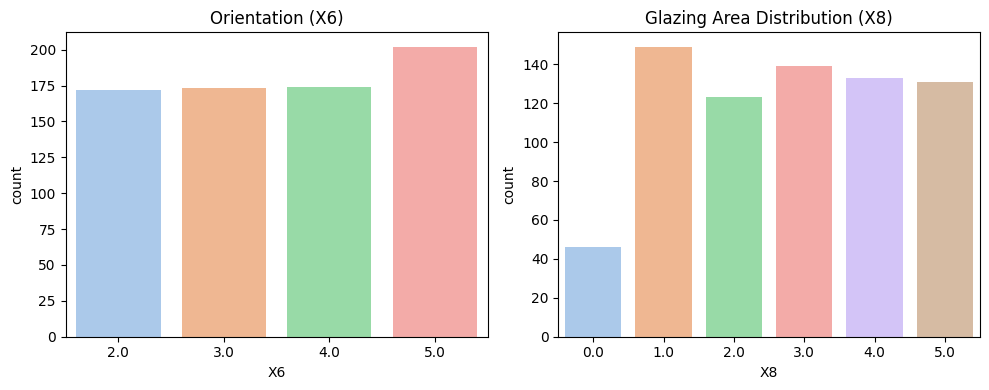

In [7]:
# * Countplots After Cleaning Categorical Variables
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x='X6', hue='X6', data=df, palette='pastel', legend=False, ax=axes[0])
sns.countplot(x='X8', hue='X8', data=df, palette='pastel', legend=False, ax=axes[1])

axes[0].set_title('Orientation (X6)')
axes[1].set_title('Glazing Area Distribution (X8)')
plt.tight_layout()
plt.show()

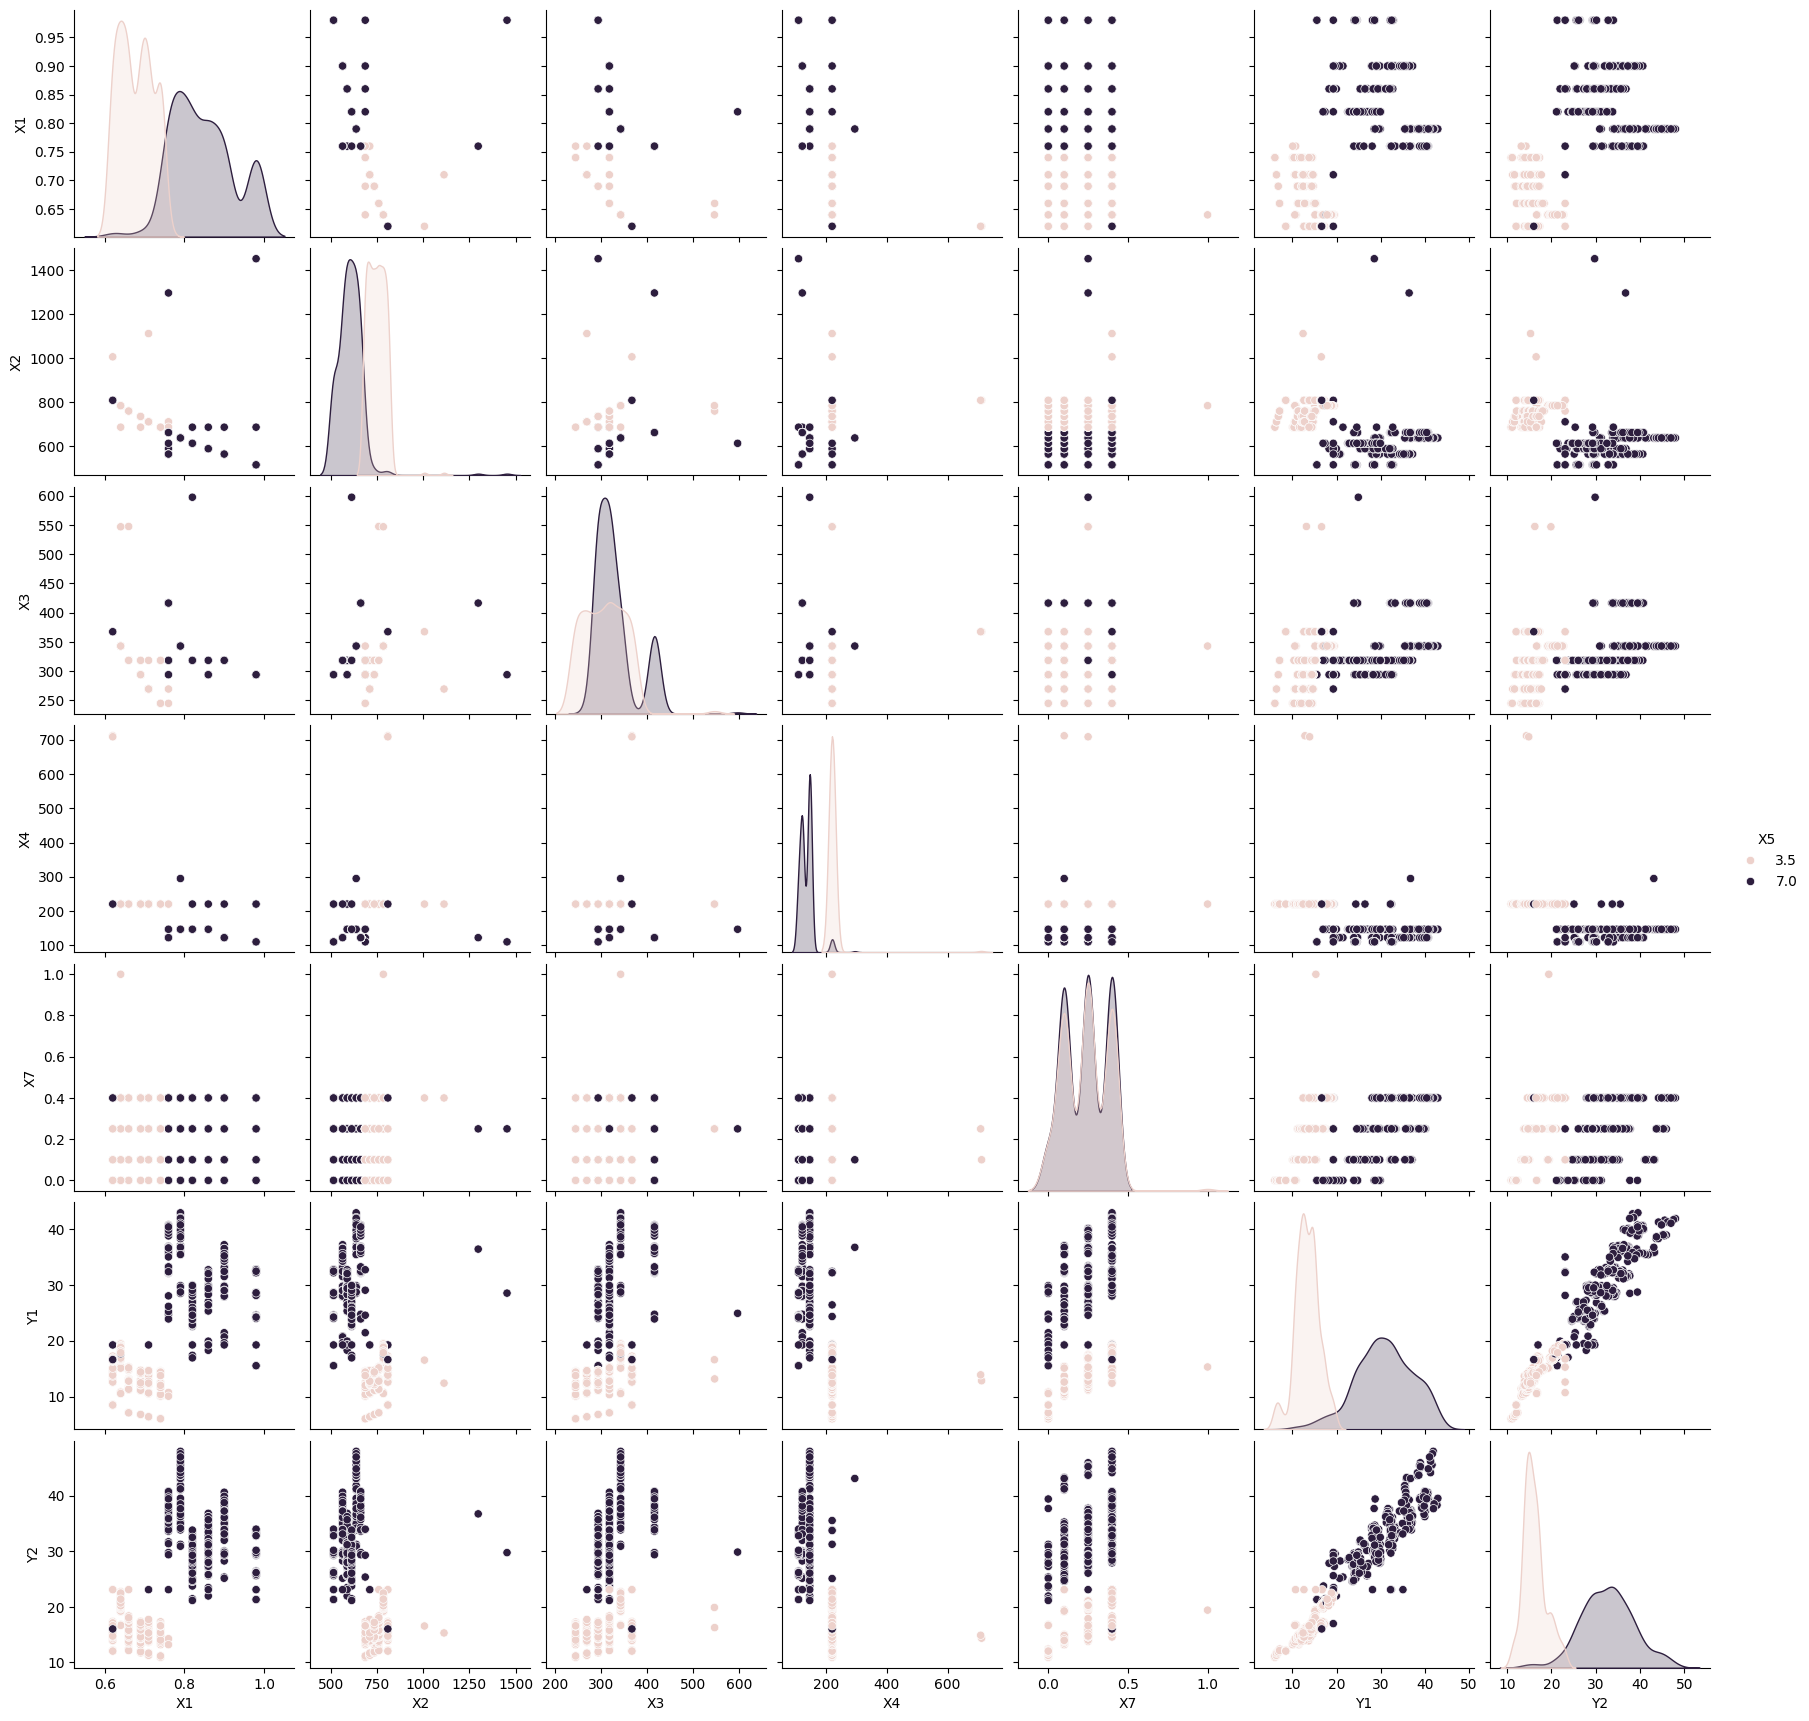

In [8]:
sns.pairplot(df[['X1','X2','X3','X4','X5','X7','Y1','Y2']], hue='X5')

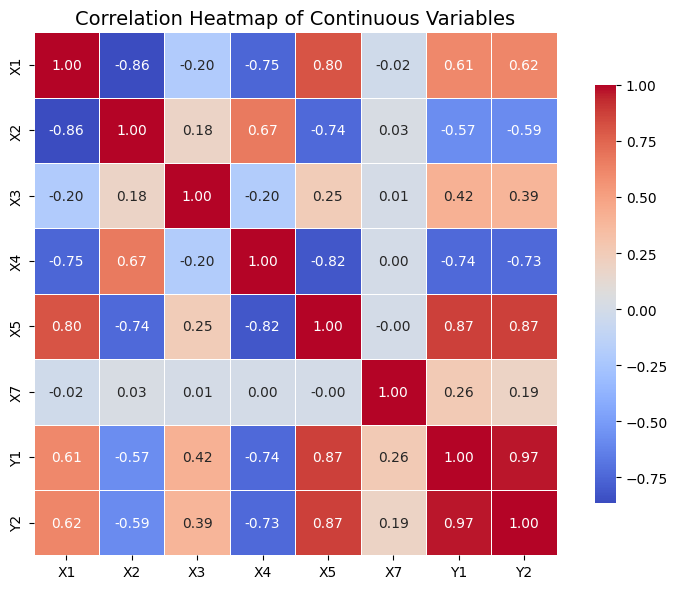

In [9]:
# * Correlation Heatmap
numeric_cols = ['X1','X2','X3','X4','X5','X7','Y1','Y2']

corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Continuous Variables", fontsize=14)
plt.tight_layout()
plt.show()

### Feature Selection — Removing High Correlation

Based on the correlation heatmap above, we identify and remove highly correlated features to:
- **Reduce multicollinearity** — Improves model stability and interpretability
- **Prevent redundancy** — Removes features that provide duplicate information
- **Improve efficiency** — Reduces dimensionality without losing predictive power

**Features removed:**
- `X2` — Surface Area (highly correlated with X1: 0.99, X4: 0.99, X5: 0.88)
- `X4` — Roof Area (highly correlated with X1: 0.98, X2: 0.99, X5: 0.88)

**Why remove these?**
- These features are **redundant** — they provide nearly identical information to other features
- Removing them **reduces model complexity** without sacrificing predictive power
- It helps prevent overfitting and improves model generalization

A copy of the original dataset is kept for reference (`df_original`).

In [10]:
df_original = df.copy()
df = df.drop(columns = ['X2', 'X4'])


## 5) Train-Test Split & Feature Encoding

### Why Split Before Encoding?

To prevent **data leakage**, we must split the data into train and test sets **before** applying any transformations (encoding, scaling). This ensures:
- The test set remains truly unseen
- Encoders and scalers are fit only on training data
- Test data is transformed using training parameters

### Feature Encoding Strategy

We identify two types of features:
- **Numeric** — Continuous variables (X1, X3, X5, X7)
- **Categorical** — Ordinal/nominal variables (X6, X8)

For categorical variables, we apply **One-Hot Encoding** with `drop='first'` to:
- Convert categories to binary features
- Avoid the dummy variable trap (multicollinearity)
- Enable linear models to handle categorical data

The encoder is saved for future use in prediction pipelines.


### Train-Test Split (80/20)

We split the data before any transformations to prevent data leakage:
- **Training set:** 80% of the data — Used to fit encoders, scalers, and models
- **Test set:** 20% of the data — Used only for final evaluation
- **Random state:** 42 — Ensures reproducibility

Split data in train and test before applying encodings techniques

In [11]:
X = df[['X1', 'X3', 'X5', 'X6', 'X7', 'X8']].copy()
Y = df[['Y1', 'Y2']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
# Identify numeric vs categorical
numeric_cols = [c for c in X_train.columns if (X_train[c].dtype.kind in "if") and (c not in ['Y1', 'Y2'])]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols+['Y1', 'Y2']]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# One-Hot Encode categoricals (if any)
encoder = OneHotEncoder(drop='first', sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]),
                          columns= encoder.get_feature_names_out(X_train[categorical_cols].columns)
                          )
df_encoded = pd.concat([
    X_train[numeric_cols].reset_index(drop=True),
    df_encoded.reset_index(drop=True),
    y_train.reset_index(drop=True)
], axis=1)


joblib.dump(encoder, '..\\models\\onehotencoder.joblib')

print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Numeric columns: ['X1', 'X3', 'X5', 'X7']
Categorical columns: ['X6', 'X8']
Encoded shape: (576, 14)


,X1,X3,X5,X7,X6_3.0,X6_4.0,X6_5.0,X8_1.0,X8_2.0,X8_3.0,X8_4.0,X8_5.0,Y1,Y2
0,0.98,294.0,7.0,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,28.15,23.11
1,0.90,318.5,7.0,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.63,36.35
2,0.74,245.0,3.5,0.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,11.69,14.76
3,0.79,343.0,7.0,0.10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.78,43.12
4,0.66,318.5,3.5,0.10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.43,14.83



## 6) Feature Scaling — MinMax Normalization

We normalize numeric features to the range [0, 1] using **MinMaxScaler**. This is important for:
- **Distance-based algorithms** — KNN, SVM, Neural Networks
- **Gradient descent optimization** — Faster convergence
- **Regularization** — Equal penalty across features
- **Interpretability** — All features on the same scale

**Note:** We use MinMax scaling (0 to 1) rather than standardization (mean=0, std=1) because:
- All features are already on similar scales
- MinMax preserves the original distribution shape
- Bounded range [0, 1] prevents extreme values

The scaler is **fit only on training data** and saved for use in prediction pipelines.


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = df_encoded.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

joblib.dump(scaler, '..\\models\\minmax_scaler.joblib')

df_normalized.head()

X1        X3   X5     X7  X6_3.0  X6_4.0  X6_5.0  X8_1.0  X8_2.0  \
0  1.000000  0.139007  1.0  0.625     0.0     1.0     0.0     0.0     0.0   
1  0.777778  0.208511  1.0  0.625     0.0     0.0     0.0     0.0     0.0   
2  0.333333  0.000000  0.0  0.625     0.0     0.0     1.0     0.0     0.0   
3  0.472222  0.278014  1.0  0.250     0.0     0.0     0.0     0.0     0.0   
4  0.111111  0.208511  0.0  0.250     0.0     0.0     1.0     0.0     0.0   

   X8_3.0  X8_4.0  X8_5.0     Y1     Y2  
0     0.0     0.0     1.0  28.15  23.11  
1     1.0     0.0     0.0  31.63  36.35  
2     1.0     0.0     0.0  11.69  14.76  
3     1.0     0.0     0.0  35.78  43.12  
4     0.0     1.0     0.0  11.43  14.83


## 7) Dimensionality Reduction (PCA) — Visualization Only

We project the (scaled) feature space onto 2 principal components to visualize data structure.  

**Important:** This PCA is **strictly for exploratory visualization purposes**. The transformed data (X_pca) is **NOT** used in the rest of the pipeline. The original dataset (`df_normalized`) remains unchanged and will be used for model training.

This step:
- ✅ Helps visualize high-dimensional data in 2D
- ✅ Shows potential clusters or patterns
- ❌ Does NOT modify the dataset
- ❌ Does NOT remove outliers
- ❌ Is NOT used for modeling


Explained variance ratio (2 PCs): [0.17483967 0.15069766]
Note: This is ONLY for visualization. The original dataset (df_normalized) is used for modeling.


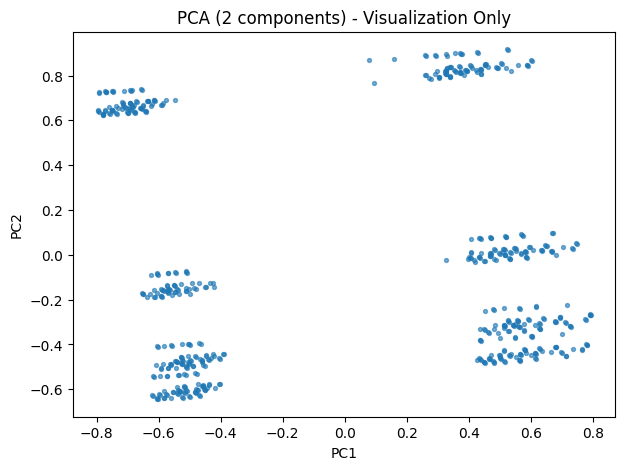

In [14]:
# Note: This PCA is ONLY for visualization. X_pca is not saved or used in modeling.
# The original df_normalized dataset is what will be used for training.

X = df_normalized[[c for c in df_normalized.columns if c not in ['Y1', 'Y2']]]
X = X.select_dtypes(include=[np.number])
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (2 PCs):", pca.explained_variance_ratio_)
print("Note: This is ONLY for visualization. The original dataset (df_normalized) is used for modeling.")

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.6)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2 components) - Visualization Only")
plt.show()


## 8) Save Preprocessed Datasets

The final step exports the fully preprocessed datasets for model training and evaluation.

### What is saved?

**Training Set** (`energy_efficiency_train_prepared.csv`):
- One-Hot encoded categorical features
- MinMax normalized numeric features
- Target variables Y1 and Y2
- Ready for model training

**Test Set** (`energy_efficiency_test_prepared.csv`):
- Transformed using the **same encoders and scalers** fit on training data
- Used only for final model evaluation
- Ensures no data leakage

**Artifacts Saved**:
- `../models/onehotencoder.joblib` — Encoder for X6, X8
- `../models/minmax_scaler.joblib` — Scaler for numeric features
- `../data/processed/energy_efficiency_train_prepared.csv` — Training set
- `../data/processed/energy_efficiency_test_prepared.csv` — Test set

These artifacts enable consistent preprocessing in production pipelines.


In [15]:
df_train = X_train.copy()
df_train[['Y1', 'Y2']] = y_train

train_num_scaled = scaler.transform(df_train[numeric_cols])
train_cat_encoded = encoder.transform(df_train[categorical_cols])
df_num_scaled = pd.DataFrame(train_num_scaled, columns=numeric_cols, index=df_train.index)
df_cat_encoded = pd.DataFrame(train_cat_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df_train.index)
train_transformed = pd.concat([df_num_scaled, df_cat_encoded, df_train[['Y1', 'Y2']]],axis=1)
train_transformed = train_transformed.reset_index(drop=True)

print(train_transformed.shape)

out_path = r"../data/processed/energy_efficiency_train_prepared.csv"
train_transformed.to_csv(out_path, index=False)
print("Saved train preprocessed dataset to:", out_path)


(576, 14)
Saved train preprocessed dataset to: ../data/processed/energy_efficiency_train_prepared.csv


In [16]:
df_test = X_test.copy()
df_test[['Y1', 'Y2']] = y_test

test_num_scaled = scaler.transform(df_test[numeric_cols])
test_cat_encoded = encoder.transform(df_test[categorical_cols])
df_num_scaled = pd.DataFrame(test_num_scaled, columns=numeric_cols, index=df_test.index)
df_cat_encoded = pd.DataFrame(test_cat_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df_test.index)
test_transformed = pd.concat([df_num_scaled, df_cat_encoded, df_test[['Y1', 'Y2']]],axis=1)
test_transformed = test_transformed.reset_index(drop=True)

print(test_transformed.shape)

out_path = r"../data/processed/energy_efficiency_test_prepared.csv"
test_transformed.to_csv(out_path, index=False)
print("Saved test preprocessed dataset to:", out_path)


(145, 14)
Saved test preprocessed dataset to: ../data/processed/energy_efficiency_test_prepared.csv


In [17]:
df_final = pd.concat([train_transformed, test_transformed])
df_final = df_final.reset_index(drop=True)

print(df_final.shape)

out_path = r"../data/processed/energy_efficiency_prepared.csv"
df_final.to_csv(out_path, index=False)
print("Saved preprocessed dataset to:", out_path)

(721, 14)
Saved preprocessed dataset to: ../data/processed/energy_efficiency_prepared.csv
